# Log Probs Experiments

## Setup

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import hashlib
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
from pprint import pprint


# Add the project root to the path to allow importing from `part2`
sys.path.insert(0, os.path.abspath('.'))
from part2.logprobs_cli import get_logprobs

sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

In [2]:
# Gemini example
result = get_logprobs(provider='gemini', model_id='gemini-2.5-flash', prompt="Hi?", top_logprobs=3)

print("Final full response:", result.response_text)
print("First token probabilites: ")
pprint(result.logprobs)

Final full response: Hi there! How can I help you today?
First token probabilites: 
{'"': 0.00010701859002946925,
 'Hello': 0.14476793021149523,
 'Hi': 0.8549225832938897}


In [4]:
# Llama3 example
result = get_logprobs(provider='ollama', model_id='llama3:8b', prompt="Hi?", top_logprobs=3)

print("Final full response:", result.response_text)
print("First token probabilites: ")
pprint(result.logprobs)

Final full response: Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?
First token probabilites: 
{'Hello': 0.03336298021198061,
 'Hey': 0.002526230201690072,
 'Hi': 0.9640619080516238}


In [ ]:
# More information is visible from the response body, but note that the logprobs of each token are predicated on the previously sampled token (NEEDS REWRITE)
result.raw_response['logprobs']

[{'token': 'Hi',
  'logprob': -0.03678377717733383,
  'bytes': [72, 105],
  'top_logprobs': [{'token': 'Hi',
    'logprob': -0.03678377717733383,
    'bytes': [72, 105]},
   {'token': 'Hello',
    'logprob': -3.395376682281494,
    'bytes': [72, 101, 108, 108, 111]},
   {'token': 'Hey', 'logprob': -5.976133823394775, 'bytes': [72, 101, 121]}]},
 {'token': '!',
  'logprob': -0.001129352836869657,
  'bytes': [33],
  'top_logprobs': [{'token': '!',
    'logprob': -0.001129352836869657,
    'bytes': [33]},
   {'token': ' there',
    'logprob': -6.821983337402344,
    'bytes': [32, 116, 104, 101, 114, 101]},
   {'token': '!I', 'logprob': -11.368570327758789, 'bytes': [33, 73]}]},
 {'token': ' It',
  'logprob': -0.015181666240096092,
  'bytes': [32, 73, 116],
  'top_logprobs': [{'token': ' It',
    'logprob': -0.015181666240096092,
    'bytes': [32, 73, 116]},
   {'token': ' How',
    'logprob': -4.414721488952637,
    'bytes': [32, 72, 111, 119]},
   {'token': ' I', 'logprob': -6.5461072921

Prompt: Please answer with H (for heads) or T (for tails) only. We flip the coin, and it turns up
Response: H
Token Probs:
{'H': 0.7802657985302739, 'T': 0.21934566818076454}


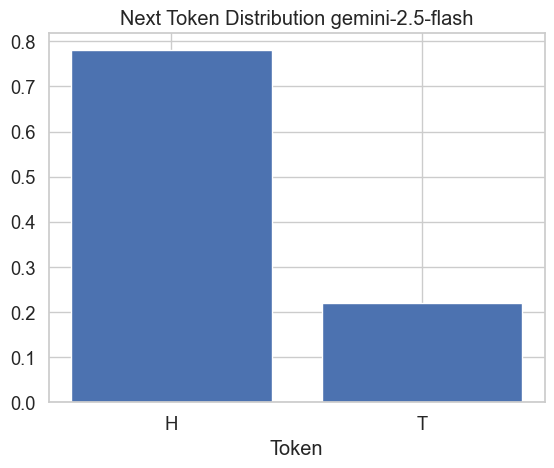

In [56]:
# Plot single response options

# Don't use LLMs as RNGs!
# Gemini is NOT deterministic even in terms of logprobs?!
from collections import OrderedDict

def token_distribution_experiment(prompt, model_id, provider, repeats=1, plot=True, verbose=True, numeric_x=False, **kwargs):

    for _ in range(repeats):
        result = get_logprobs(
            model_id=model_id,
            provider=provider,
            prompt=prompt,
            **kwargs
        )

        if verbose:
            print("Prompt:", prompt)
            print("Response:", result.response_text)
            print("Token Probs:")
            pprint(result.logprobs)

        if plot:
            # Convert token strings to integers where possible

            if numeric_x:
                numeric_logprobs = {}

                for token, logp in result.logprobs.items():
                    try:
                        token_int = int(token.strip())
                    except ValueError:
                        continue  # skip non-numeric tokens

                    if 0 <= token_int <= 10:
                        numeric_logprobs[token_int] = logp

                # Enforce fixed ordering 0–10 and fill missing with 0.0
                x_vals = list(range(0, 11))
                y_vals = [numeric_logprobs.get(i, 0.0) for i in x_vals]

                plt.bar(x_vals, y_vals)
                
                plt.xlabel("Number")
                plt.ylabel("Log probability")
                plt.xticks(x_vals)
            else:
                plt.xlabel("Token")
                plt.bar(result.logprobs.keys(), result.logprobs.values())

            plt.title(f"Next Token Distribution {model_id}")
            plt.show()



token_distribution_experiment(
    # prompt="Please answer using a single numerical. Give me a random number between 0 and 10",
    prompt="Please answer with H (for heads) or T (for tails) only. We flip the coin, and it turns up",
    top_logprobs=2,
    temperature=0.1,
    # prompt="Please answer using a single numerical. Give me a completely random two-digit number.",
    provider="gemini",
    model_id="gemini-2.5-flash"
)

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 6
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


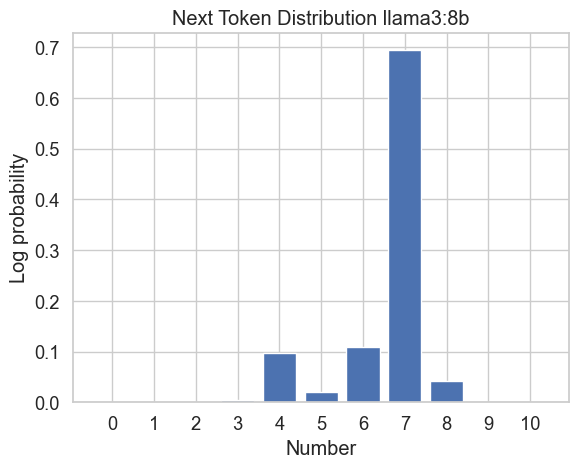

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 7
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


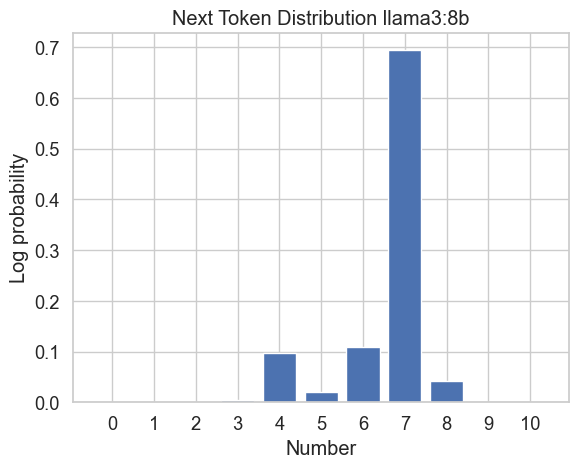

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 7
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


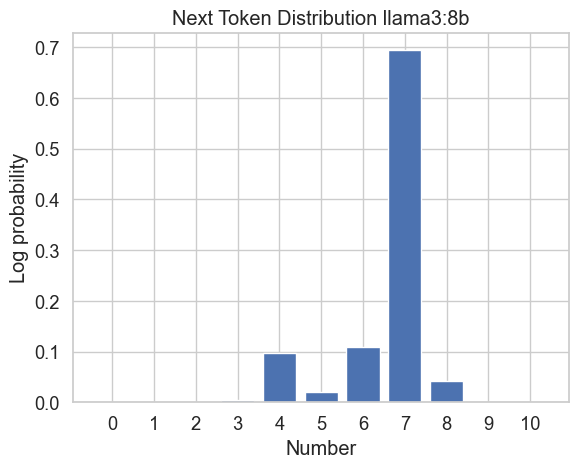

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 7
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


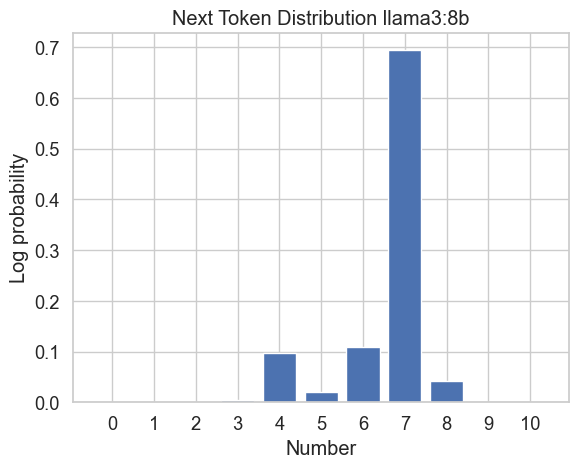

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 7
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


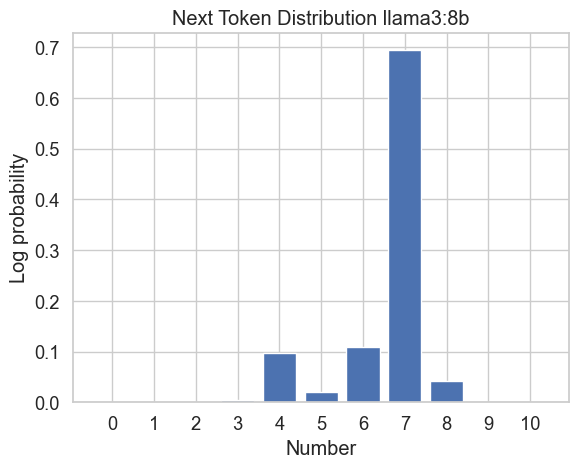

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 7
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


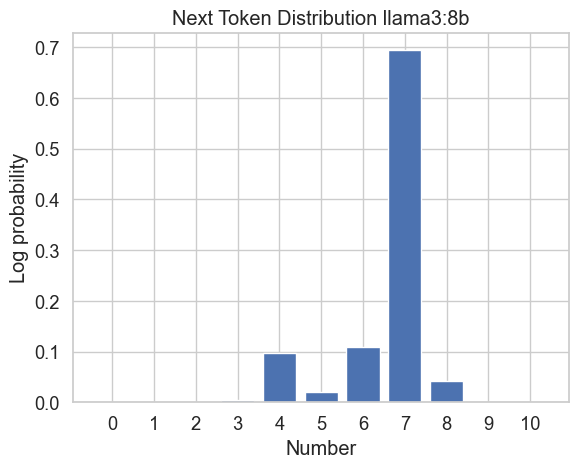

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 6
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


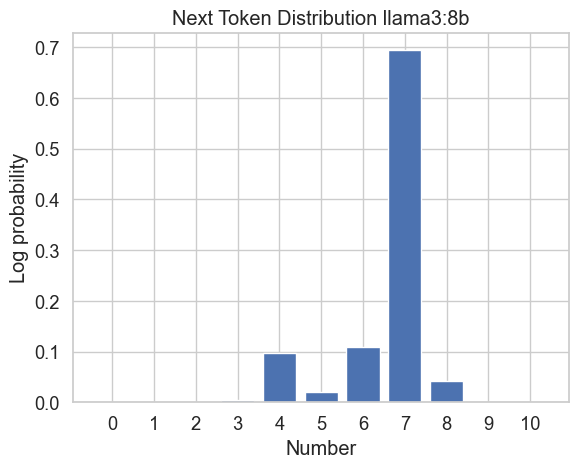

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 7
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


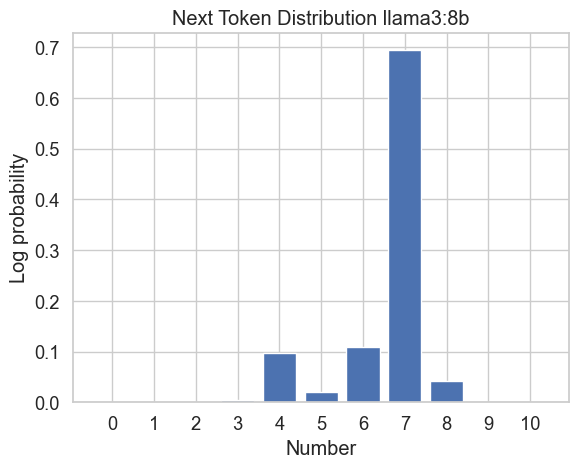

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 7
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


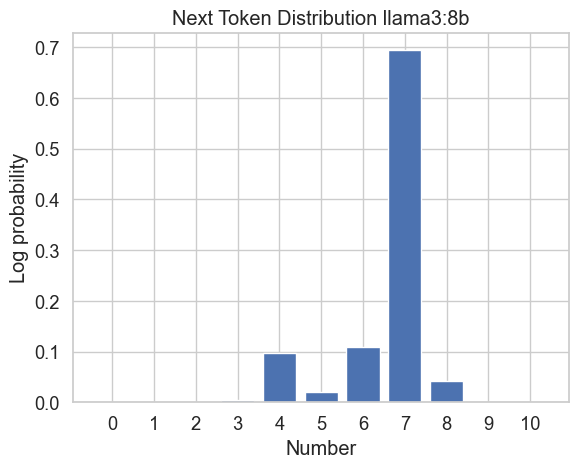

Prompt: Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10
Response: 7
Token Probs:
{'*': 0.00018754397768868782,
 '**': 0.031382183555319625,
 '3': 0.005375713693680842,
 '4': 0.0975503738777797,
 '5': 0.019608375980278318,
 '6': 0.10891708969978617,
 '7': 0.6943639737129671,
 '8': 0.041834830853652326,
 '9': 6.358338163886712e-05,
 'The': 0.0004158220939525066}


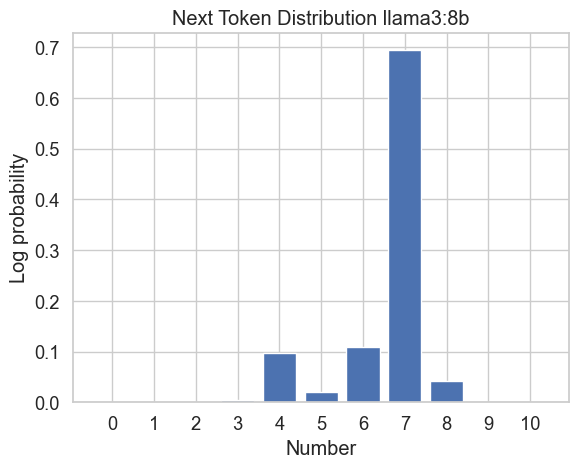

In [ ]:
# Not always determinstic?
token_distribution_experiment(
    prompt="Please answer using a single numerical. You are a random number simulator. Give me a random number between 0 and 10",
    # prompt="Please answer with H (for heads) or T (for tails) only. You are coin flip simulator that is completely fair, i.e. always returning with 50% chance either heads or tails.",
    top_logprobs=10,
    temperature=0,
    repeats=0,
    # prompt="Please answer using a single numerical. Give me a completely random two-digit number.",
    provider="ollama",
    verbose=True,
    model_id="llama3:8b",
    numeric_x=True
)

## Determinism

I am doubtful that these APIs always return deterministic answers desipite temperature=0. Lets test this.

In [92]:
# Check if token probs are always the same, 


def test_determinism(N=10, **logprob_kwargs):
    df_rows = []

    for _ in tqdm(range(N)):

        res = get_logprobs(**logprob_kwargs)
        # res.response_text
        # res.logprobs
        d = res.logprobs
        d.update({
            'response_text': res.response_text,   
        })
        # print(">>>", d)
        df_rows.append(d)
        
    return pd.DataFrame(df_rows)

top_logprobs = 10
test_determinism(provider="ollama", model_id="llama3:8b", temperature=0, top_k=3, top_logprobs=top_logprobs, prompt="Please reply in 1 number only. Give me a random number between 0 and 10.", verbose=True)

 20%|██        | 2/10 [00:03<00:11,  1.45s/it]

prompt: Please reply in 1 number only. Give me a random number between 0 and 10.
response:
{'context': [128006,
             882,
             128007,
             271,
             5618,
             10052,
             304,
             220,
             16,
             1396,
             1193,
             13,
             21335,
             757,
             264,
             4288,
             1396,
             1990,
             220,
             15,
             323,
             220,
             605,
             13,
             128009,
             128006,
             78191,
             128007,
             271,
             22],
 'created_at': '2026-01-13T05:57:30.111489Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 2,
 'eval_duration': 19006333,
 'load_duration': 2761360625,
 'logprobs': [{'bytes': [55],
               'logprob': -0.09048538655042648,
               'token': '7',
               'top_logprobs': [{'bytes': [55],
                              

 40%|████      | 4/10 [00:03<00:03,  1.71it/s]

prompt: Please reply in 1 number only. Give me a random number between 0 and 10.
response:
{'context': [128006,
             882,
             128007,
             271,
             5618,
             10052,
             304,
             220,
             16,
             1396,
             1193,
             13,
             21335,
             757,
             264,
             4288,
             1396,
             1990,
             220,
             15,
             323,
             220,
             605,
             13,
             128009,
             128006,
             78191,
             128007,
             271,
             22],
 'created_at': '2026-01-13T05:57:30.446877Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 2,
 'eval_duration': 17002875,
 'load_duration': 75308166,
 'logprobs': [{'bytes': [55],
               'logprob': -0.09068899601697922,
               'token': '7',
               'top_logprobs': [{'bytes': [55],
                                

 60%|██████    | 6/10 [00:04<00:01,  2.91it/s]

prompt: Please reply in 1 number only. Give me a random number between 0 and 10.
response:
{'context': [128006,
             882,
             128007,
             271,
             5618,
             10052,
             304,
             220,
             16,
             1396,
             1193,
             13,
             21335,
             757,
             264,
             4288,
             1396,
             1990,
             220,
             15,
             323,
             220,
             605,
             13,
             128009,
             128006,
             78191,
             128007,
             271,
             22],
 'created_at': '2026-01-13T05:57:30.77052Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 2,
 'eval_duration': 15631459,
 'load_duration': 78738000,
 'logprobs': [{'bytes': [55],
               'logprob': -0.09068899601697922,
               'token': '7',
               'top_logprobs': [{'bytes': [55],
                                 

 80%|████████  | 8/10 [00:04<00:00,  4.09it/s]

prompt: Please reply in 1 number only. Give me a random number between 0 and 10.
response:
{'context': [128006,
             882,
             128007,
             271,
             5618,
             10052,
             304,
             220,
             16,
             1396,
             1193,
             13,
             21335,
             757,
             264,
             4288,
             1396,
             1990,
             220,
             15,
             323,
             220,
             605,
             13,
             128009,
             128006,
             78191,
             128007,
             271,
             22],
 'created_at': '2026-01-13T05:57:31.102088Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 2,
 'eval_duration': 15837791,
 'load_duration': 78231542,
 'logprobs': [{'bytes': [55],
               'logprob': -0.09068899601697922,
               'token': '7',
               'top_logprobs': [{'bytes': [55],
                                

100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

prompt: Please reply in 1 number only. Give me a random number between 0 and 10.
response:
{'context': [128006,
             882,
             128007,
             271,
             5618,
             10052,
             304,
             220,
             16,
             1396,
             1193,
             13,
             21335,
             757,
             264,
             4288,
             1396,
             1990,
             220,
             15,
             323,
             220,
             605,
             13,
             128009,
             128006,
             78191,
             128007,
             271,
             22],
 'created_at': '2026-01-13T05:57:31.422679Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 2,
 'eval_duration': 16165542,
 'load_duration': 77877167,
 'logprobs': [{'bytes': [55],
               'logprob': -0.09068899601697922,
               'token': '7',
               'top_logprobs': [{'bytes': [55],
                                

,7,4,8,5,6,3,9,2,87,73,response_text
0,0.913488,0.029167,0.023877,0.015776,0.009542,0.008069,0.000053,0.000006,0.000003,0.000003,7
1,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
2,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
3,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
4,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
5,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
6,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
7,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
8,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
9,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7


In [90]:
test_determinism(provider="ollama", model_id="llama3:8b", temperature=1, top_k=3, top_logprobs=top_logprobs, prompt="Please reply in 1 number only. Give me a random number between 0 and 10.")

100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


,7,4,8,5,6,3,9,2,87,73,response_text
0,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
1,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
2,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
3,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
4,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
5,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
6,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
7,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
8,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7
9,0.913302,0.029195,0.023983,0.015796,0.009578,0.008064,0.000054,0.000006,0.000003,0.000003,7


In [20]:
questions = [
    "The capital of the Netherlands is",
    "The number of r's in the word strawberry are ",
    "The largest planet in our solar system is",
    "The chemical symbol for gold is",
    "The number of continents on Earth are",
    "The first president of the United States was",
    "Water boils at this many degrees celsius: ",
    "The speed of light is approximately",
    "The smallest prime number is",
    "The author of Romeo and Juliet is",
    "The capital of Japan is",
    "The number of days in a leap year are",
    "The longest river in the world is",
    "A pH value of under 7 indicates that a substance is",
    "The currency of the United Kingdom is",
    "The square root of 144 is",
    "The tallest mountain on Earth is",
    "The freezing point of water is",
    "The number of sides on a hexagon are",
    "The largest ocean on Earth is",
    "The chemical formula for water is",
    "The capital of France is",
    "The number of planets in our solar system are",
    "The inventor of the telephone was",
    "Pi rounded to two decimal places is",
    "The number of bones in the adult human body are approximately",
    "The capital of Australia is",
    "The number of hours in a day are",
    "The smallest country in the world is",
    "The year World War II ended was",
    "The number of strings on a standard guitar are",
    "The capital of Canada is",
    "The hardest natural substance on Earth is",
    "The number of weeks in a year are",
    "The closest star to Earth is",
    "The symbol for iron on the periodic table is",
    "The number of teeth in an adult human are typically",
    "The capital of Italy is",
    "The boiling point of water in Fahrenheit is",
    "The largest mammal on Earth is",
    "The number of seconds in a minute are",
    "The capital of Spain is",
    "The first man on the moon was",
    "The number of zeros in one million are",
    "The smallest bone in the human body is",
    "The capital of Germany is",
    "The number of players on a soccer team are",
    "The gas that plants absorb from the atmosphere is",
    "The distance from Earth to the Sun is approximately",
    "The capital of Egypt is",
    "The number of letters in the English alphabet are",
    "The fastest land animal is",
    "The year the Titanic sank was",
    "The capital of Brazil is",
    "The number of degrees in a right angle are",
    "The largest desert in the world is",
    "The chemical symbol for silver is",
    "The capital of China is",
    "The number of chambers in the human heart are",
    "The smallest planet in our solar system is",
    "The capital of Russia is",
    "The number of cents in a dollar are",
    "The organ that pumps blood through the body is",
    "The capital of India is",
    "The number of minutes in an hour are",
    "The largest land animal is",
    "The year Columbus reached the Americas was",
    "The capital of Mexico is",
    "The number of stripes on the American flag are",
    "The process by which plants make food is called",
    "The capital of South Korea is",
    "The number of legs on a spider are",
    "The coldest planet in our solar system is",
    "The symbol for sodium on the periodic table is",
    "The capital of Argentina is",
    "The number of cents in a quarter are",
    "The largest island in the world is",
    "The capital of Turkey is",
    "The number of sides on a triangle are",
    "The hottest planet in our solar system is",
    "The year the Berlin Wall fell was",
    "The capital of Sweden is",
    "The number of Great Lakes are",
    "The longest bone in the human body is",
    "The capital of Norway is",
    "The number of degrees in a circle are",
    "The metal that is liquid at room temperature is",
    "The capital of Greece is",
    "The number of keys on a standard piano are",
    "The smallest unit of life is",
    "The capital of Portugal is",
    "The number of stars on the American flag are",
    "The force that pulls objects toward Earth is",
    "The capital of Poland is",
    "The number of rings on the Olympic flag are",
    "The year the internet was invented was approximately",
    "The capital of Denmark is",
    "The number of inches in a foot are",
    "The red planet is",
    "The capital of Finland is"
]

In [21]:
len(questions)

100

In [22]:
# Some metrics to measure logprobs
import scipy.special


def _truncate_and_normalize(logprob_dict, k):
    """
    Take top-k tokens from a {token: logprob} dict and return
    (tokens, probs) where probs are normalized probabilities.
    """
    items = sorted(logprob_dict.items(), key=lambda x: x[1], reverse=True)[:k]

    tokens = [tok for tok, _ in items]
    logps = np.array([lp for _, lp in items], dtype=float)

    logZ = scipy.special.logsumexp(logps)
    probs = np.exp(logps - logZ)

    return tokens, probs


def truncated_entropy(logprob_dict, k=10):
    """
    Entropy over top-k tokens using log-sum-exp normalization.
    """
    items = sorted(logprob_dict.items(), key=lambda x: x[1], reverse=True)[:k]
    logps = np.array([lp for _, lp in items], dtype=float)

    logZ = scipy.special.logsumexp(logps)
    probs = np.exp(logps - logZ)

    return -np.sum(probs * np.log(probs + 1e-12))


def top1_top2_logprob_gap(logprob_dict):
    """
    Difference in log-probability between best and second-best token.
    """
    items = sorted(logprob_dict.items(), key=lambda x: x[1], reverse=True)

    if len(items) < 2:
        raise ValueError("Need at least two tokens to compute gap")

    return items[0][1] - items[1][1]


def semantic_entropy(logprob_dict, k=10):
    """
    Entropy over semantically-normalized answer strings.
    Groups token variants like 'Am', 'Amsterdam', etc.
    Note that this is still flawed as similar tokens may not always be simple subsets of each other. 
    A better solution would be to use embeddings and some sort of distance metric
    """
    tokens, probs = _truncate_and_normalize(logprob_dict, k)

    clusters = {}
    for tok, p in zip(tokens, probs):
        key = tok.strip().lower()
        clusters[key] = clusters.get(key, 0.0) + p

    cluster_probs = np.array(list(clusters.values()))
    return -np.sum(cluster_probs * np.log(cluster_probs + 1e-12))

In [ ]:
# Investigate determinism, does the same prompt, return the same answer, even with temp set to 0?

# Note that temp doesn't matter for the log probs!
temp = 0

# prompt = "Please answer in 1 number only. The number of r's in the word strawberry are "
prompt_template = "Please answer with your answer only, without any introduction or other explaining text. {question}"

# Accumulate logprob values, cache and 
def get_logprobs_for_questions(questions, model_ids, providers, use_cache=True):
    if isinstance(model_ids, str):
        model_ids = [model_ids]
    if isinstance(providers, str):
        providers = [providers]
    assert len(model_ids) == len(providers), "Providers should be of same length as model_ids"

    cache_hash = hashlib.sha256(
        json.dumps([questions, model_ids, providers], sort_keys=True).encode('utf-8')
    ).hexdigest()
    print("hash:", cache_hash)
    
    cache_file = f'.cached_logprobs_{cache_hash}.pkl'
    if use_cache:
        if os.path.exists(cache_file):
            df = pd.read_pickle(cache_file)
            print(f"Loaded {len(df)} cached results from {cache_file}")
            return df

    df_rows = []

    for provider, model_id in zip(providers, model_ids):
        for q in tqdm(questions, desc=model_id):
            prompt = prompt_template.format(question=q)    
            logprobs = get_data(
                provider=provider,
                prompt=prompt,
                model_id=model_id, 
                top_logprobs=10,
                invert_log=False
            )
            prob_vals = list(x for x in logprobs.values())
            logprob_var = np.var(prob_vals) # Not a good metric due to long tails

            df_rows.append({
                'provider': provider,
                'model_id': model_id,
                'question': q,
                'prompt': prompt,
                'response': 
                'logprob_var': logprob_var,
                'truncated_entropy': truncated_entropy(logprobs, k=10),
                'semantic_entropy': semantic_entropy(logprobs, k=10),
                'top1_top2_gap': top1_top2_logprob_gap(logprobs),
                'logprob_vals': prob_vals
                'logprob_dict': 
            })

    df = pd.DataFrame(df_rows)
    df.to_pickle(cache_file)
    print(f"Saved file to {cache_file}")

    return df


providers = ["ollama", 'ollama', 'gemini', 'openai']
model_ids = ["llama3:8b", 'dolphin-mistral:latest', 'gemini-2.5-flash', 'gpt-4o-mini']


df = get_logprobs_for_questions(questions, model_ids=model_ids, providers=providers, use_cache=True)
df

hash: 5886fb6f833fb51811fb608c6372baccf6549cedfee07fd90334360034990884
Loaded 400 cached results from .cached_logprobs_5886fb6f833fb51811fb608c6372baccf6549cedfee07fd90334360034990884.pkl


,provider,model_id,question,prompt,logprob_var,truncated_entropy,semantic_entropy,top1_top2_gap,logprob_vals
0,ollama,llama3:8b,The capital of the Netherlands is,"Please answer with your answer only, without a...",17.540348,0.001600,1.107550e-03,9.343910,"[-0.00014904298586770892, -9.344058990478516, ..."
1,ollama,llama3:8b,The number of r's in the word strawberry are,"Please answer with your answer only, without a...",13.287828,1.100379,1.100379e+00,0.228617,"[-0.8367975950241089, -1.065414309501648, -1.5..."
2,ollama,llama3:8b,The largest planet in our solar system is,"Please answer with your answer only, without a...",16.887214,0.008817,8.796504e-03,6.866913,"[-0.001101486966945231, -6.868014335632324, -1..."
3,ollama,llama3:8b,The chemical symbol for gold is,"Please answer with your answer only, without a...",24.855857,0.010850,8.190766e-05,6.633944,"[-0.0013903281651437283, -6.635334014892578, -..."
4,ollama,llama3:8b,The number of continents on Earth are,"Please answer with your answer only, without a...",20.979120,0.003372,3.367760e-03,8.022562,"[-0.0003641968360170722, -8.022926330566406, -..."
...,...,...,...,...,...,...,...,...,...
395,openai,gpt-4o-mini,The year the internet was invented was approxi...,"Please answer with your answer only, without a...",28.880624,0.695118,6.951179e-01,1.000000,"[-0.3415290415287018, -1.3415290117263794, -3...."
396,openai,gpt-4o-mini,The capital of Denmark is,"Please answer with your answer only, without a...",37.400624,0.000004,3.916840e-06,15.375000,"[-3.128163257315464e-07, -15.375, -18.125, -19..."
397,openai,gpt-4o-mini,The number of inches in a foot are,"Please answer with your answer only, without a...",35.660000,0.000001,1.156455e-06,17.875000,"[0.0, -17.875, -17.875, -18.0, -19.5, -19.875,..."
398,openai,gpt-4o-mini,The red planet is,"Please answer with your answer only, without a...",39.600624,0.000003,4.904864e-07,15.875000,"[-1.9361264946837764e-07, -15.875, -17.875, -1..."


In [17]:
# Lets try and find 'uncertain' answers
df.sort_values('truncated_entropy', ascending=False).groupby('model_id', as_index=False).head(1)

,provider,model_id,question,prompt,logprob_var,truncated_entropy,semantic_entropy,top1_top2_gap,logprob_vals
143,ollama,dolphin-mistral:latest,The number of zeros in one million are,"Please answer with your answer only, without a...",0.732172,2.026946,2.026946,0.439019,"[-1.5576655864715576, -1.9966847896575928, -2...."
213,gemini,gemini-2.5-flash,The human body has,"Please answer with your answer only, without a...",0.947752,1.701209,1.655959,1.171623,"[-0.98625374, -2.157877, -2.7244034, -2.830869..."
13,ollama,llama3:8b,The human body has,"Please answer with your answer only, without a...",2.030940,1.436282,1.413346,1.141108,"[-0.6570155620574951, -1.7981231212615967, -2...."
313,openai,gpt-4o-mini,The human body has,"Please answer with your answer only, without a...",3.694375,0.855266,0.798217,1.875000,"[-0.30363699793815613, -2.1786370277404785, -2..."


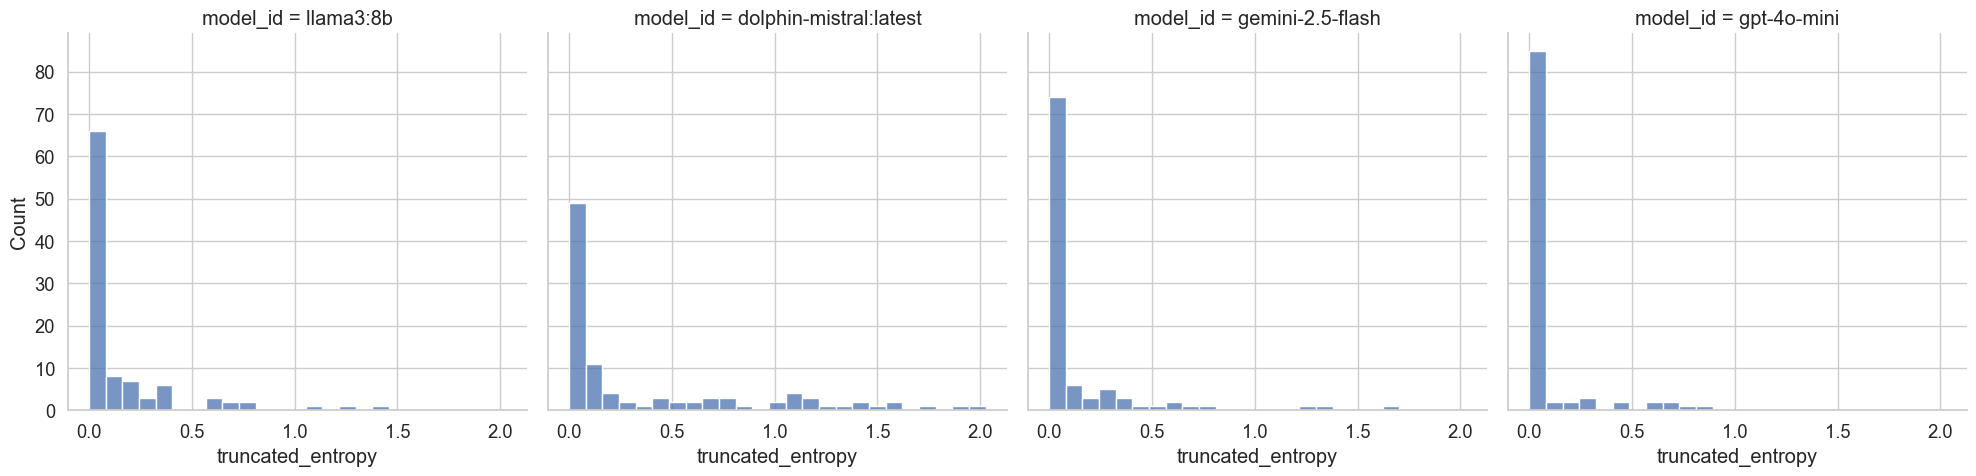

In [13]:

sns.displot(
    data=df,
    x="truncated_entropy",
    col="model_id",
    bins=25,
    col_wrap=len(model_ids),
    kind="hist",
    facet_kws={"sharex": True, "sharey": True}
)


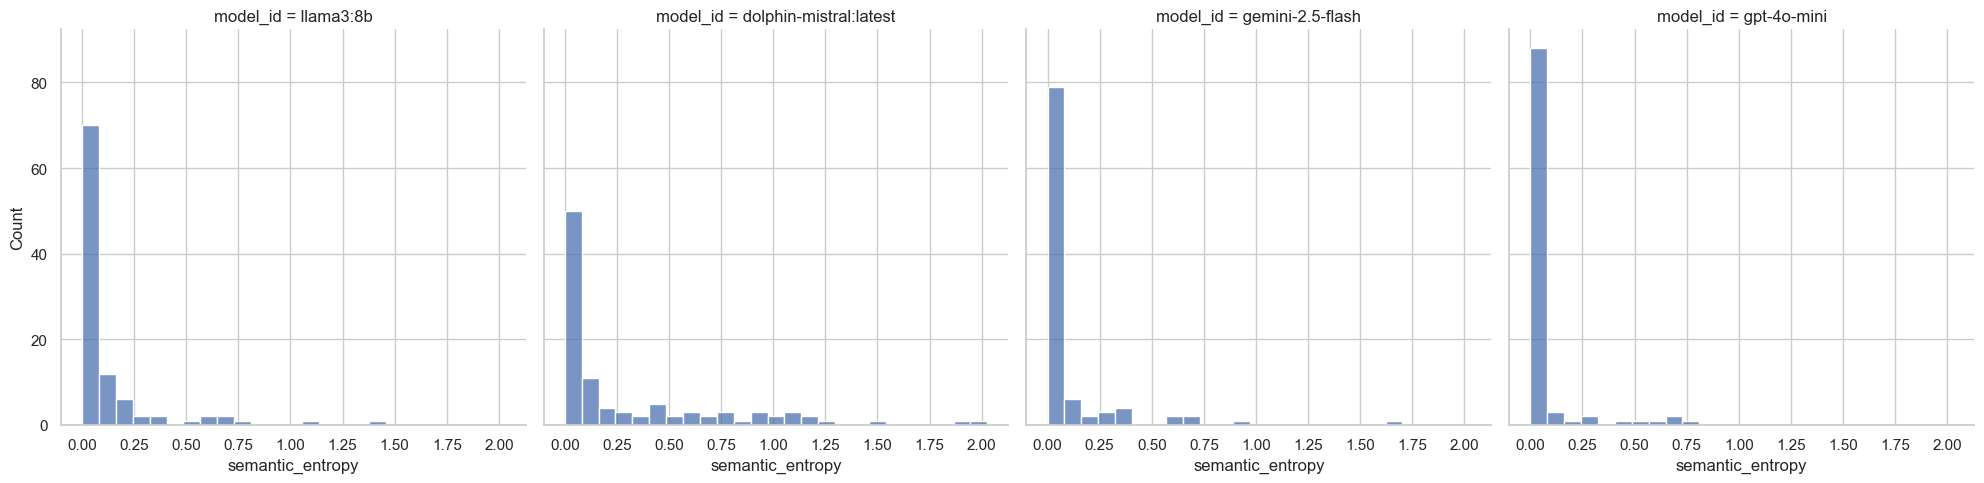

In [ ]:

sns.displot(
    data=df,
    x="semantic_entropy",
    col="model_id",
    bins=25,
    col_wrap=len(model_ids),
    kind="hist",
    facet_kws={"sharex": True, "sharey": True}
)


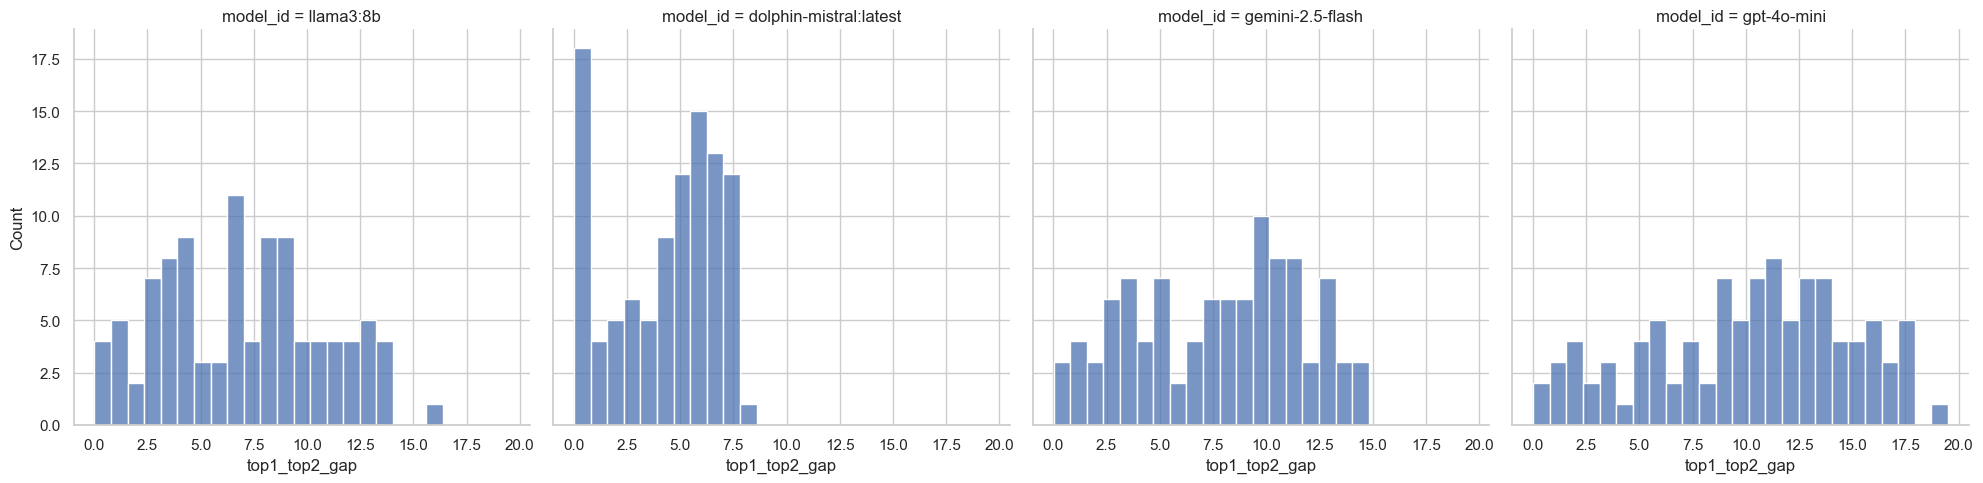

In [ ]:

sns.displot(
    data=df,
    x="top1_top2_gap",
    col="model_id",
    bins=25,
    col_wrap=len(model_ids),
    kind="hist",
    facet_kws={"sharex": True, "sharey": True}
).;

In [1]:
df

NameError: name 'df' is not defined

## Prompt Experiment

In [ ]:
prompts = {
    "Freeform": "The capital of the Netherlands is",
    "Binary": "Is Amsterdam the capital of the Netherlands? (Yes/No)",
    "Multiple Choice": "The capital of the Netherlands is: A) The Hague, B) Amsterdam, C) Rotterdam",
    "Poor Prompt": "Netherlands capital?"
}

fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
axes = axes.flatten()
fixed_temp = 1.0

for i, (title, prompt) in enumerate(prompts.items()):
    logprobs = get_data(
        provider="gemini",
        prompt=prompt,
        model_id="gemini-1.5-flash",
        temperature=fixed_temp
    )
    
    tokens = [item[0] for item in logprobs]
    probs = [item[1] for item in logprobs]
    
    sns.barplot(x=tokens, y=probs, ax=axes[i], palette="plasma")
    axes[i].set_title(f"Prompt: {title}")
    axes[i].set_ylabel("Probability")
    axes[i].set_xlabel("Token")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle(f"Next Token Probabilities for Different Prompts (Temp={fixed_temp})", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()